<a href="https://colab.research.google.com/github/guptapawan227/Capstone_AIML/blob/Ashitha/Capstone_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

Importing Libraries

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import time, os, sys, itertools, re 
from PIL import Image
import warnings, pickle, string
from dateutil import parser
%matplotlib inline

# Data Visualization
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

from ftfy import fix_text, badness

Reading the data from excel 

In [ ]:
#data=pd.read_excel('/content/drive/MyDrive/Capstone/input_data.xlsx')
data=pd.read_excel('input_data.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


Exploratory Data Analysis

In [ ]:
data.head()

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
2  \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group  
0            GRP_0  
1            GRP_0  
2            GRP_0  
3            GRP_0  
4            GRP_0

In [ ]:
assignment_group_count=data['Assignment group'].value_counts()
assignment_group_count.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

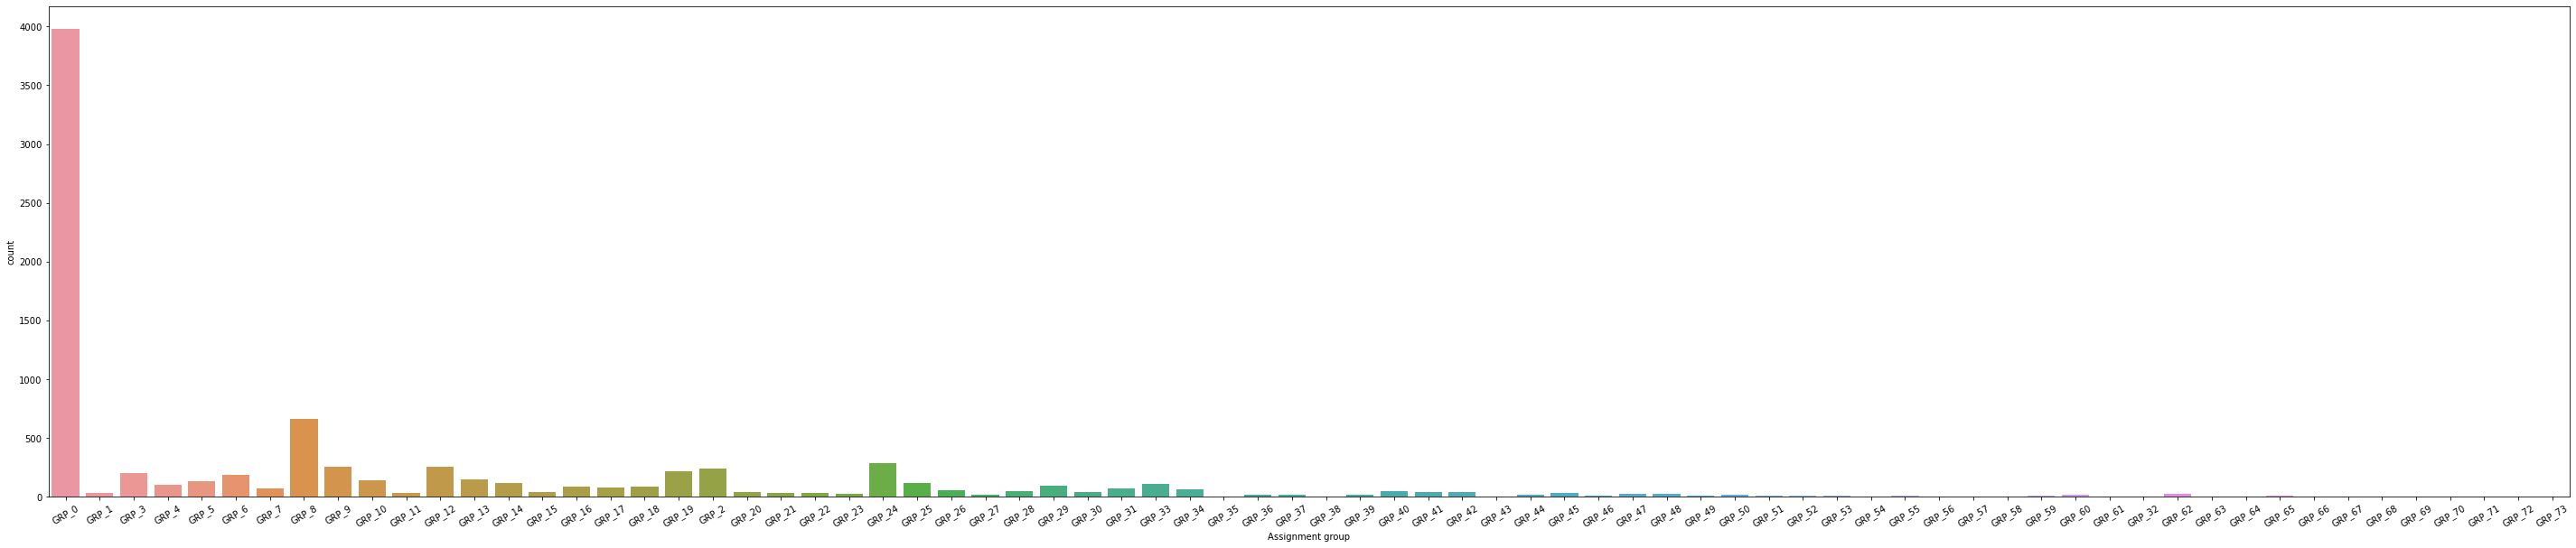

In [ ]:
plt.subplots(figsize=(50,10))
ax=sns.countplot(x='Assignment group', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.tight_layout
plt.show()


Check Missing Values in dataframe

In [ ]:
data.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [ ]:
data[data["Short description"].isnull()]

Short description                                        Description  \
2604               NaN  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...   
3383               NaN  \r\n-connected to the user system using teamvi...   
3906               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3910               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3915               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3921               NaN  -user unable  tologin to vpn.\r\n-connected to...   
3924               NaN  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...   
4341               NaN  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...   

                 Caller Assignment group  
2604  ohdrnswl rezuibdt           GRP_34  
3383  qftpazns fxpnytmk            GRP_0  
3906  awpcmsey ctdiuqwe            GRP_0  
3910  rhwsmefo tvphyura            GRP_0  
3915  hxripljo efzounig            GRP_0  
3921  cziadygo veiosxby            GRP_0  
3924  wvqgbdhm fwchqjor            GRP_0  
4341  eqmuniov ehxkcbgj            GRP_0

Copy Short Description to Description if the Description value is NaN

In [ ]:
data[data["Description"].isnull()]=data["Short description"]

In [ ]:
data[data["Description"].isnull()]

Empty DataFrame
Columns: [Short description, Description, Caller, Assignment group]
Index: []

In [ ]:
data['Short description'] = data['Short description'].replace(np.nan, '', regex=True)

In [ ]:
data.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

## Create a rule based engine

In [ ]:
#df_rules = pd.read_csv('/content/drive/MyDrive/Capstone/Rule_matrix.csv')
df_rules = pd.read_csv("Rule_matrix.csv")

In [ ]:
def applyRules(datadf,rulesdf,Description,ShortDescription):
    datadf['pred_group'] = np.nan
    for i, row in rulesdf.iterrows():
        for j, row in datadf.iterrows():
            if pd.notna(datadf[ShortDescription][j]):
                if (('erp' in datadf[ShortDescription][j]) and (('EU_tool' in datadf[ShortDescription][j]))):
                        datadf['pred_group'][j] = 'GRP_25'
        for j, row in datadf.iterrows():
            if pd.notna(datadf[Description][j]):
                if (datadf[Description][j] == 'the'):
                        datadf['pred_group'][j] = 'GRP_17' 
                
                if (('finance_app' in datadf[ShortDescription][j]) and ('HostName_1132' not in datadf[ShortDescription][j])):
                    datadf['pred_group'][j] = 'GRP_55'
                
                if (('processor' in datadf[Description][j]) and ('engg' in datadf[Description][j])):
                    datadf['pred_group'][j] = 'GRP_58'
        
        if rulesdf['Short Desc Rule'][i] == 'begins with' and rulesdf['Desc Rule'][i] == 'begins with' and pd.isna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if pd.notna(datadf[ShortDescription][j]) and pd.notna(datadf[Description][j]):
                    if ((datadf[ShortDescription][j].startswith(rulesdf['Short Dec Keyword'][i])) and (datadf[Description][j].startswith(rulesdf['Dec keyword'][i]))):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if pd.isna(rulesdf['Short Desc Rule'][i]) and rulesdf['Desc Rule'][i] == 'begins with' and pd.notna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if pd.notna(datadf[Description][j]) and pd.notna(datadf['Caller'][j]):
                    if ((datadf[Description][j].startswith(rulesdf['Desc Rule'][i]) and (rulesdf['User'][i] == datadf['Caller'][j]))):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if rulesdf['Short Desc Rule'][i] == 'contains' and pd.notna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if (pd.notna(datadf[ShortDescription][j]) and pd.notna(datadf['Caller'][j])):
                     if ((rulesdf['Short Dec Keyword'][i] in datadf[ShortDescription][j]) and (rulesdf['User'][i] == datadf['Caller'][j])):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if rulesdf['Short Desc Rule'][i] == 'contains' and pd.isna(rulesdf['Desc Rule'][i]) and pd.isna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                #print(j)
                if pd.notna(datadf[ShortDescription][j]):
                    if (rulesdf['Short Dec Keyword'][i] in datadf[ShortDescription][j]):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if pd.isna(rulesdf['Short Desc Rule'][i]) and rulesdf['Desc Rule'][i] == 'begins with' and pd.isna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if pd.notna(datadf[Description][j]):
                    if (datadf[Description][j].startswith(rulesdf['Dec keyword'][i])):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
        if pd.isna(rulesdf['Short Desc Rule'][i]) and rulesdf['Desc Rule'][i] == 'contains' and pd.isna(rulesdf['User'][i]):
            for j, row in datadf.iterrows():
                if pd.notna(datadf[Description][j]):
                    if (rulesdf['Dec keyword'][i] in datadf[Description][j]):
                        datadf['pred_group'][j] = rulesdf['Group'][i]
       

    return datadf

In [ ]:
rules_applied_df = applyRules(data,df_rules,'Description','Short description')
rules_applied_df

Short description  \
0                                           login issue   
1                                               outlook   
2                                    cant log in to vpn   
3                         unable to access hr_tool page   
4                                          skype error    
...                                                 ...   
8495                  emails not coming in from zz mail   
8496                           telephony_software issue   
8497  vip2: windows password reset for tifpdchb pedx...   
8498                     machine nÃ£o estÃ¡ funcionando   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                            Description             Caller  \
0     -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1     \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
2     \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...  eylqgodm ybqkwiam   
3                         unable to access hr_tool page  xbkucsvz gcpydteq   
4                                          skype error   owlgqjme qhcozdfx   
...                                                 ...                ...   
8495  \r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...  avglmrts vhqmtiua   
8496                           telephony_software issue  rbozivdq gmlhrtvp   
8497  vip2: windows password reset for tifpdchb pedx...  oybwdsgx oxyhwrfz   
8498  i am unable to access the machine utilities to...  ufawcgob aowhxjky   
8499  an mehreren pc`s lassen sich verschiedene prgr...  kqvbrspl jyzoklfx   

     Assignment group pred_group  
0               GRP_0        NaN  
1               GRP_0        NaN  
2               GRP_0        NaN  
3               GRP_0        NaN  
4               GRP_0        NaN  
...               ...        ...  
8495           GRP_29        NaN  
8496            GRP_0        NaN  
8497            GRP_0        NaN  
8498           GRP_62        NaN  
8499           GRP_49        NaN  

[8500 rows x 5 columns]

In [ ]:
rules_applied_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8500 non-null   object
 1   Description        8500 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
 4   pred_group         296 non-null    object
dtypes: object(5)
memory usage: 332.2+ KB


In [ ]:
rules_applied_df = rules_applied_df[(rules_applied_df['pred_group'].isna())]
rules_applied_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8204 entries, 0 to 8499
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8204 non-null   object
 1   Description        8204 non-null   object
 2   Caller             8204 non-null   object
 3   Assignment group   8204 non-null   object
 4   pred_group         0 non-null      object
dtypes: object(5)
memory usage: 384.6+ KB


### Concatenate Short Description and Description Column into New Description, drop the previous columns

In [ ]:
#Concatenate Short Description and Description columns
rules_applied_df['New Description'] = rules_applied_df['Description'] + ' ' +rules_applied_df['Short description']

clean_data=rules_applied_df.drop(['Short description', 'Description', 'pred_group'], axis=1)


In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8204 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Caller            8204 non-null   object
 1   Assignment group  8204 non-null   object
 2   New Description   8204 non-null   object
dtypes: object(3)
memory usage: 576.4+ KB


## Fixing Garbled Text/ Mojibake using ftfy library

In [ ]:
# Write a function to apply to the dataset to detect Mojibakes
def is_mojibake_impacted(text):
    if not badness.sequence_weirdness(text):
        # nothing weird, should be okay
        return True
    try:
        text.encode('sloppy-windows-1252')
    except UnicodeEncodeError:
        # Not CP-1252 encodable, probably fine
        return True
    else:
        # Encodable as CP-1252, Mojibake alert level high
        return False
# Check the dataset for mojibake impact
clean_data[~clean_data.iloc[:,:].applymap(is_mojibake_impacted).all(1)]

Caller Assignment group  \
99    ecprjbod litmjwsy            GRP_0   
116   bgqpotek cuxakvml            GRP_0   
124   tvcdfqgp nrbcqwgj            GRP_0   
164   tycludks cjofwigv            GRP_0   
170   fbvpcytz nokypgvx           GRP_18   
...                 ...              ...   
8470  azxhejvq fyemlavd           GRP_16   
8471  xqyjztnm onfusvlz           GRP_30   
8480  nlearzwi ukdzstwi            GRP_9   
8498  ufawcgob aowhxjky           GRP_62   
8499  kqvbrspl jyzoklfx           GRP_49   

                                        New Description  
99    \n\nreceived from: ecprjbod.litmjwsy@gmail.com...  
116   \r\n\r\nreceived from: bgqpotek.cuxakvml@gmail...  
124   from: tvcdfqgp nrbcqwgj \nsent: friday, octobe...  
164   \n\nreceived from: abcdri@company.com\n\nwindy...  
170   \n\nreceived from: fbvpcytz.nokypgvx@gmail.com...  
...                                                 ...  
8470  from: mikhghytr wafglhdrhjop \nsent: thursday,...  
8471  to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥ ç”µ...  
8480  \r\n\r\nreceived from: nlearzwi.ukdzstwi@gmail...  
8498  i am unable to access the machine utilities to...  
8499  an mehreren pc`s lassen sich verschiedene prgr...  

[820 rows x 3 columns]

In [ ]:
# Take an example of row# 8471 Short Desc and fix it
print('Grabled text: \033[1m%s\033[0m\nFixed text: \033[1m%s\033[0m' % (clean_data['New Description'][8471], 
                                                                        fix_text(clean_data['New Description'][8471])))

# List all mojibakes defined in ftfy library
print('\nMojibake Symbol RegEx:\n', badness.MOJIBAKE_SYMBOL_RE.pattern)

Grabled text: to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥ ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥
Fixed text: to 小贺,早上电脑开机开不出来 电脑开机开不出来

Mojibake Symbol RegEx:
 [ÂÃÎÏÐÑØÙĂĎĐŃŘŮ][-€ƒ‚„†‡ˆ‰‹Œ“•˜œŸ¡¢£¤¥¦§¨ª«¬¯°±²³µ¶·¸¹º¼½¾¿ˇ˘˝]|[ÂÃÎÏÐÑØÙĂĎĐŃŘŮ][›»‘”´©™]\w|×[-ƒ‚„†‡ˆ‰‹Œ“•˜œŸ¡¦§¨ª«¬¯°²³ˇ˘›‘”´©™]|[¬√][ÄÅÇÉÑÖÜáàâäãåçéèêëíìîïñúùûü†¢£§¶ß®©™≠ÆØ¥ªæø≤≥]|\w√[±∂]\w|◊|[ðđ][Ÿ]|â€|вЂ[љћ¦°№™ќ“”]


In [ ]:
# Sanitize the dataset from Mojibakes
clean_data['New Description'] = clean_data['New Description'].apply(fix_text)

# Visualize that row# 8471
clean_data.loc[8471]

Caller                      xqyjztnm onfusvlz
Assignment group                       GRP_30
New Description     to 小贺,早上电脑开机开不出来 电脑开机开不出来
Name: 8471, dtype: object

## Cleaning & Processing the data

In [ ]:
def date_validity(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

In [ ]:

def process(text_string):
    text=text_string.lower()
    text_string = ' '.join([w for w in text_string.split() if not date_validity(w)])
    text_string = re.sub(r"received from:",'',text_string)
    text_string = re.sub(r"from:",' ',text_string)
    text_string = re.sub(r"to:",' ',text_string)
    text_string = re.sub(r"subject:",' ',text_string)
    text_string = re.sub(r"sent:",' ',text_string)
    text_string = re.sub(r"ic:",' ',text_string)
    text_string = re.sub(r"cc:",' ',text_string)
    text_string = re.sub(r"bcc:",' ',text_string)
    text_string = re.sub(r'\S*@\S*\s?', '', text_string)
    text_string = re.sub(r'\d+','' ,text_string)
    text_string = re.sub(r'\n',' ',text_string)
    text_string = re.sub(r'#','', text_string)
    text_string = re.sub(r'&;?', 'and',text_string)
    text_string = re.sub(r'\&\w*;', '', text_string)
    text_string = re.sub(r'https?:\/\/.*\/\w*', '', text_string)  
    text_string= ''.join(c for c in text_string if c <= '\uFFFF') 
    text_string = text_string.strip()
    text_string = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text_string).split())
    text_string = re.sub(r"\s+[a-zA-Z]\s+", ' ', text_string)
    text_string = re.sub(' +', ' ', text_string)
    text_string = text_string.strip()
    return text_string
  

In [ ]:
clean_data["Clean_Description"] = clean_data["New Description"].apply(process)

In [ ]:
clean_data

Caller Assignment group  \
0     spxjnwir pjlcoqds            GRP_0   
1     hmjdrvpb komuaywn            GRP_0   
2     eylqgodm ybqkwiam            GRP_0   
3     xbkucsvz gcpydteq            GRP_0   
4     owlgqjme qhcozdfx            GRP_0   
...                 ...              ...   
8495  avglmrts vhqmtiua           GRP_29   
8496  rbozivdq gmlhrtvp            GRP_0   
8497  oybwdsgx oxyhwrfz            GRP_0   
8498  ufawcgob aowhxjky           GRP_62   
8499  kqvbrspl jyzoklfx           GRP_49   

                                        New Description  \
0     -verified user details.(employee# & manager na...   
1     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...   
2     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...   
3     unable to access hr_tool page unable to access...   
4                             skype error  skype error    
...                                                 ...   
8495  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...   
8496  telephony_software issue telephony_software issue   
8497  vip2: windows password reset for tifpdchb pedx...   
8498  i am unable to access the machine utilities to...   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                      Clean_Description  
0     verified user details employee and manager nam...  
1     hello team my meetings skype meetings etc are ...  
2       hi cannot log on to vpn best cant log in to vpn  
3     unable to access hr tool page unable to access...  
4                               skype error skype error  
...                                                 ...  
8495  good afternoon am not receiving the emails tha...  
8496  telephony software issue telephony software issue  
8497  vip windows password reset for tifpdchb pedxru...  
8498  i am unable to access the machine utilities to...  
8499  an mehreren pc lassen sich verschiedene prgram...  

[8204 rows x 4 columns]

## Translation

In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple, https://urm.nvidia.com/artifactory/api/pypi/sw-colossus-pypi/simple


In [ ]:
from langdetect import detect
    
def fn_lang_detect(df):                                        
   try:                                                          
      return detect(df)                                      
   except:                                                       
      return 'no'                                                  

clean_data['language'] = clean_data['Clean_Description'].apply(fn_lang_detect)

C:\Users\aroy\Anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



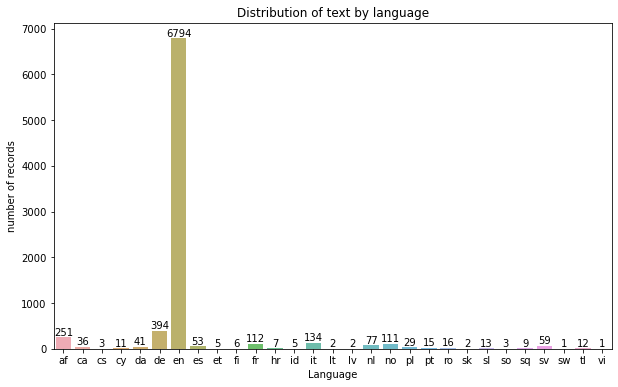

In [ ]:
x = clean_data["language"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

We can see that most of the tickets are in english, followed by tickets in German language. We need to translate these into english.

In [ ]:
#german_data = pd.read_csv("/content/drive/MyDrive/Capstone/german.csv")
german_data = pd.read_csv('german.csv')

In [ ]:
german_data

German English
0              ich       I
1              sie     you
2              das     the
3              ist      is
4               du     you
...            ...     ...
10392  vereinigung   Union
10393  mittelpunkt   Focus
10394         page    page
10395     andeuten   imply
10396       helene  helene

[10397 rows x 2 columns]

In [ ]:
german_dictionary = german_data.to_dict(orient='records')


In [ ]:

def translate_function(text):
    translated_text = []
    text_split = text.split()
    for text in text_split:
        word_found = False
        for item in range(len(german_dictionary)):
            if text == german_dictionary[item]["German"]:
                translated_text.append(german_dictionary[item]["English"])
                word_found = True
        if word_found == False:
            translated_text.append(text)
    translate = ' '.join([word for word in translated_text])        
    return translate

clean_data["Translated Text"] = clean_data["Clean_Description"].apply(translate_function)

In [ ]:
clean_data["Translated Text"].iloc[0:4]

0    verified user details employee and Manager Sur...
1    hello team my meetings skype meetings etc are ...
2      Hi cannot log on to vpn best cant log in to vpn
3    unable to access hr tool page unable to access...
Name: Translated Text, dtype: object

In [ ]:
clean_data["Clean_Description"].iloc[0:4]

0    verified user details employee and manager nam...
1    hello team my meetings skype meetings etc are ...
2      hi cannot log on to vpn best cant log in to vpn
3    unable to access hr tool page unable to access...
Name: Clean_Description, dtype: object

In [ ]:
clean_data.tail(10)

Caller Assignment group  \
8490  mpihysnw wrctgoan           GRP_29   
8491  jxgobwrm qkugdipo           GRP_34   
8492  tmopbken ibzougsd            GRP_0   
8493  ipwjorsc uboapexr           GRP_10   
8494  cpmaidhj elbaqmtp            GRP_3   
8495  avglmrts vhqmtiua           GRP_29   
8496  rbozivdq gmlhrtvp            GRP_0   
8497  oybwdsgx oxyhwrfz            GRP_0   
8498  ufawcgob aowhxjky           GRP_62   
8499  kqvbrspl jyzoklfx           GRP_49   

                                        New Description  \
8490  please contact ed pasgryowski (pasgryo) about ...   
8491  \n\nreceived from: jxgobwrm.qkugdipo@gmail.com...   
8492  hr_tool etime option not visitble  hr_tool eti...   
8493  i am sorry, i have another two accounts that n...   
8494  tablet needs reimaged due to multiple issues w...   
8495  \n\nreceived from: avglmrts.vhqmtiua@gmail.com...   
8496  telephony_software issue telephony_software issue   
8497  vip2: windows password reset for tifpdchb pedx...   
8498  i am unable to access the machine utilities to...   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                      Clean_Description language  \
8490  please contact ed pasgryowski pasgryo about hi...       en   
8491  i need vpn for my new laptop name llv knethyen...       en   
8492  hr tool etime option not visitble hr tool etim...       en   
8493  i am sorry have another two accounts that need...       en   
8494  tablet needs reimaged due to multiple issues w...       en   
8495  good afternoon am not receiving the emails tha...       en   
8496  telephony software issue telephony software issue       en   
8497  vip windows password reset for tifpdchb pedxru...       en   
8498  i am unable to access the machine utilities to...       en   
8499  an mehreren pc lassen sich verschiedene prgram...       de   

                                        Translated Text  
8490  please contact ed pasgryowski pasgryo about hi...  
8491  i need vpn for my new Laptop Surname llv kneth...  
8492  hr tool etime option distress visitble hr tool...  
8493  i at the sorry have another two accounts did n...  
8494  tablet needs reimaged due to multiple issues w...  
8495  good afternoon at the distress receiving the e...  
8496  telephony software issue telephony software issue  
8497  vip windows password reset for tifpdchb pedxru...  
8498  i at the unable to access the machine utilitie...  
8499  at more pc to let themselves various prgramdnt...

In [ ]:
clean_data[clean_data.language == 'de']

Caller Assignment group  \
133   bihypqsn kbaegpcd            GRP_0   
223   vrfpyjwi nzhvgqiw           GRP_24   
265   fcyuqvoj ajqeidlm            GRP_0   
270   nemzycxb xpsgkahw            GRP_0   
272   lpfwkotn keycvxsl            GRP_0   
...                 ...              ...   
8432  ZkBogxib QsEJzdZO            GRP_8   
8439  kiqrvwat gwkpxzyt           GRP_33   
8448  ZkBogxib QsEJzdZO            GRP_8   
8462  ZkBogxib QsEJzdZO            GRP_9   
8499  kqvbrspl jyzoklfx           GRP_49   

                                        New Description  \
133   install driver in printer hr14 in HostName_769...   
223   hallo ,\n\nes ist erneut passiert. der pc hat ...   
265   \n\nreceived from: fcyuqvoj.ajqeidlm@gmail.com...   
270   neues passwort für accountname tgryhu hgygrtui...   
272   drucker / scanner em85678\n \n scanner findet ...   
...                                                 ...   
8432  received from: monitoring_tool@company.com\n\n...   
8439  der drucker steht am platz von wckrxovs aunsgz...   
8448  received from: monitoring_tool@company.com\n\n...   
8462  received from: monitoring_tool@company.com\n\n...   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                      Clean_Description language  \
133   install driver in printer hr in HostName insta...       de   
223   hallo es ist erneut passiert der pc hat sich z...       de   
265   hallo netweaver funktioniert nicht mehr bzw ka...       de   
270   neues passwort r accountname tgryhu hgygrtui p...       de   
272   drucker scanner em scanner findet pfad nicht m...       de   
...                                                 ...      ...   
8432  abended job in job scheduler Job at abended jo...       de   
8439  der drucker steht am platz von wckrxovs aunsgz...       de   
8448  abended job in job scheduler Job at abended jo...       de   
8462  abended job in job scheduler Job at abended jo...       de   
8499  an mehreren pc lassen sich verschiedene prgram...       de   

                                        Translated Text  
133   install driver in printer hr in HostName insta...  
223   Hello it is again happens the pc Has themselve...  
265   Hello netweaver works Not more bzw can I Not m...  
270   new password r accountname tgryhu hgygrtui pas...  
272   drucker scanner em scanner finds path Not more...  
...                                                 ...  
8432  abended job in job scheduler Job at abended jo...  
8439  the drucker stands at the space from wckrxovs ...  
8448  abended job in job scheduler Job at abended jo...  
8462  abended job in job scheduler Job at abended jo...  
8499  at more pc to let themselves various prgramdnt...  

[394 rows x 6 columns]

In [ ]:
#!pip install goslate

In [ ]:
'''# Define and construct the service urls
domains = ['.com','.com.au','.com.ar','.co.kr','.co.in','.co.jp','.at','.de','.ru','.ch','.fr','.es','.ae']
urls = ['http://translate.google' + domain for domain in domains]'''

"# Define and construct the service urls\ndomains = ['.com','.com.au','.com.ar','.co.kr','.co.in','.co.jp','.at','.de','.ru','.ch','.fr','.es','.ae']\nurls = ['http://translate.google' + domain for domain in domains]"

In [ ]:
"""from goslate import Goslate # Provided by Google
import random

# List of column data to consider for translation
trans_cols = ['Clean_Description']

for idx in range(clean_data.shape[0]):
    # Instantiate Goslate class in each iteration
    gs = Goslate(service_urls=random.choice(urls))
    row_iter = gs.translate(clean_data.loc[idx, trans_cols].tolist(), 
                            target_language='en', 
                            source_language='auto')
    clean_data.loc[idx, trans_cols] = list(row_iter)
    time.sleep(30)
    
clean_data.tail()"""

"from goslate import Goslate # Provided by Google\nimport random\n\n# List of column data to consider for translation\ntrans_cols = ['Clean_Description']\n\nfor idx in range(clean_data.shape[0]):\n    # Instantiate Goslate class in each iteration\n    gs = Goslate(service_urls=random.choice(urls))\n    row_iter = gs.translate(clean_data.loc[idx, trans_cols].tolist(), \n                            target_language='en', \n                            source_language='auto')\n    clean_data.loc[idx, trans_cols] = list(row_iter)\n    time.sleep(30)\n    \nclean_data.tail()"

In [ ]:
# Serialize the translated dataset
clean_data.to_csv('translated_data.csv', index=False, encoding='utf_8_sig')
with open('translated_data.pkl','wb') as f:
    pickle.dump(clean_data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the translated pickle file 
with open('translated_data.pkl','rb') as f:
    clean_data = pickle.load(f)

### Univariate visualization
Single-variable or univariate visualization is the simplest type of visualization which consists of observations on only a single characteristic or attribute. Univariate visualization includes histogram, bar plots and line charts.

#### The distribution of Assignment groups
Plots how the assignments groups are scattered across the dataset. The bar chart, histogram and pie chart tells the frequency of any ticket assigned to any group OR the tickets count for each group.

In [ ]:
init_notebook_mode()
cf.go_offline()

# Assignment group distribution
print('\033[1mTotal assignment groups:\033[0m', clean_data['Assignment group'].nunique())

# Histogram
clean_data['Assignment group'].iplot(
    kind='hist',
    xTitle='Assignment Group',
    yTitle='count',
    title='Assignment Group Distribution- Histogram (Fig-1)')

# Pie chart
assgn_grp = pd.DataFrame(clean_data.groupby('Assignment group').size(),columns = ['Count']).reset_index()
assgn_grp.iplot(
    kind='pie', 
    labels='Assignment group', 
    values='Count', 
    title='Assignment Group Distribution- Pie Chart (Fig-2)', 
    hoverinfo="label+percent+name", hole=0.25)


Total assignment groups: 63


### Lets visualize the percentage of incidents per assignment group

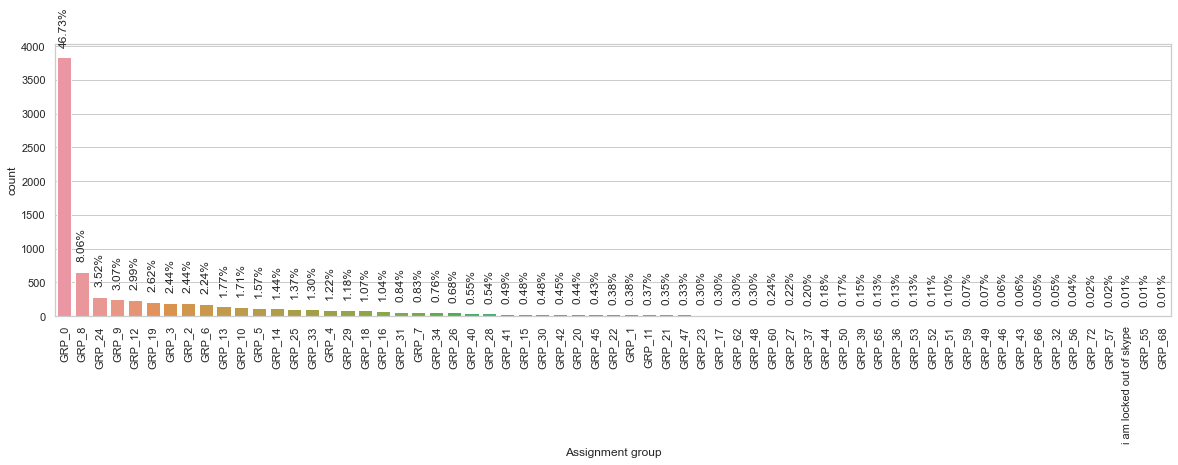

In [ ]:
# Plot to visualize the percentage data distribution across different groups
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=clean_data, order=clean_data["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(str(format(p.get_height()/len(clean_data.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

In [ ]:
top_20 = clean_data['Assignment group'].value_counts().nlargest(20).reset_index()

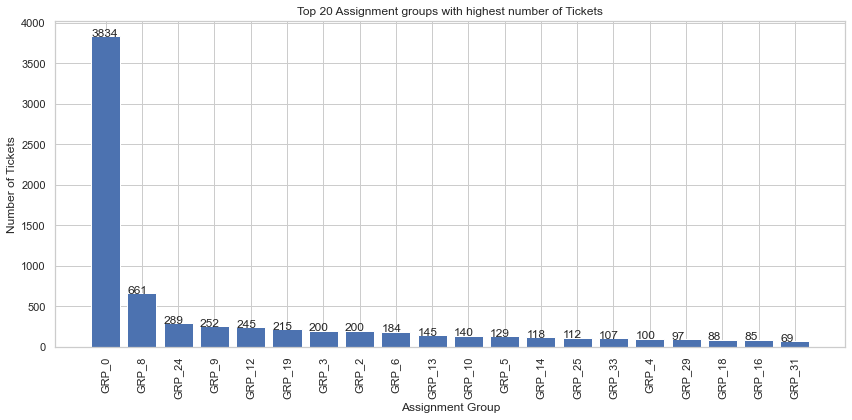

In [ ]:
plt.figure(figsize=(12,6))
bars = plt.bar(top_20['index'],top_20['Assignment group'])
plt.title('Top 20 Assignment groups with highest number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

In [ ]:
bottom_20 = clean_data['Assignment group'].value_counts().nsmallest(20).reset_index()

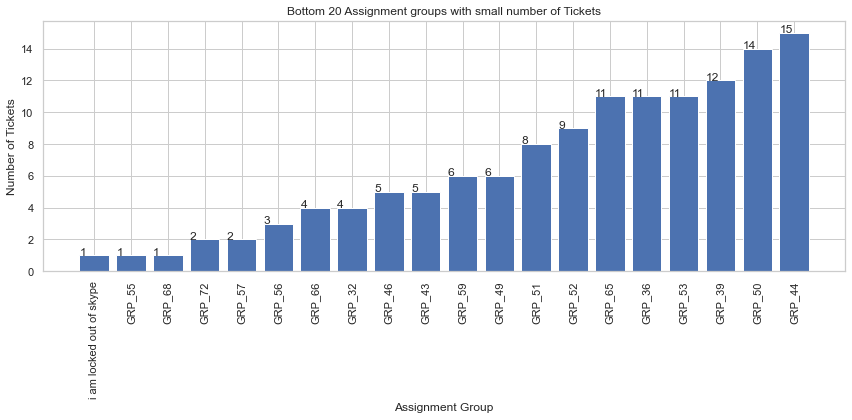

In [ ]:
plt.figure(figsize=(12,6))
bars = plt.bar(bottom_20['index'],bottom_20['Assignment group'])
plt.title('Bottom 20 Assignment groups with small number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

#### The distribution of Callers
Plots how the callers are associated with tickets and what are the assignment groups they most frequently raise tickets for.

In [ ]:
# Find out top 10 callers in terms of frequency of raising tickets in the entire dataset
print('\033[1mTotal caller count:\033[0m', clean_data['Caller'].nunique())
df = pd.DataFrame(clean_data.groupby(['Caller']).size().nlargest(10), columns=['Count']).reset_index()
df.iplot(kind='pie',
         labels='Caller', 
         values='Count', 
         title='Top 10 caller- Pie Chart (Fig-7)',
         colorscale='-spectral',
         pull=[0,0,0,0,0.05,0.1,0.15,0.2,0.25,0.3])

Total caller count: 2863


In [ ]:
# Top 5 callers in each assignment group
top_n = 5
s = clean_data['Caller'].groupby(clean_data['Assignment group']).value_counts()
caller_grp = pd.DataFrame(s.groupby(level=0).nlargest(top_n).reset_index(level=0, drop=True))
caller_grp.head(15)

Caller
Assignment group Caller                   
GRP_0            fumkcsji sarmtlhy     132
                 rbozivdq gmlhrtvp      86
                 olckhmvx pcqobjnd      54
                 efbwiadp dicafxhv      45
                 mfeyouli ndobtzpw      13
GRP_1            bpctwhsn kzqsbmtp       6
                 jloygrwh acvztedi       4
                 jyoqwxhz clhxsoqy       3
                 spxqmiry zpwgoqju       3
                 kbnfxpsy gehxzayq       2
GRP_10           bpctwhsn kzqsbmtp      60
                 ihfkwzjd erbxoyqk       6
                 dizquolf hlykecxa       5
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3

In [ ]:
# Check if any caller appears to raise ticket for multiple groups
mul_caller = caller_grp[caller_grp.Caller.duplicated()]
uni_mul_caller = [idx[1] for idx in mul_caller.index[mul_caller.Caller.unique()]]
print(f'\033[1mFollowing {len(uni_mul_caller)} callers happen to raise tickets for multiple groups:\033[0m\n')
print(uni_mul_caller)

Following 13 callers happen to raise tickets for multiple groups:

['hlrmufzx qcdzierm', 'fbgetczn jlsvxura', 'gnasmtvx cwxtsvkm', 'ihfkwzjd erbxoyqk', 'nuhfwplj ojcwxser', 'tghrloks jbgcvlmf', 'jwqyxbzs adpvilqu', 'jyoqwxhz clhxsoqy', 'vlymsnej whlqxcst', 'bpctwhsn kzqsbmtp', 'dkmcfreg anwmfvlg', 'rkupnshb gsmzfojw', 'hbmwlprq ilfvyodx']


#### The distribution of description lengths
Plots the variation of length and word count of new description attribute

In [ ]:
clean_data.insert(1, 'desc_len', clean_data['Clean_Description'].astype(str).apply(len))
clean_data.insert(5, 'desc_word_count', clean_data['Clean_Description'].apply(lambda x: len(str(x).split())))
clean_data.head()

Caller  desc_len Assignment group  \
0  spxjnwir pjlcoqds       204            GRP_0   
1  hmjdrvpb komuaywn       142            GRP_0   
2  eylqgodm ybqkwiam        47            GRP_0   
3  xbkucsvz gcpydteq        59            GRP_0   
4  owlgqjme qhcozdfx        23            GRP_0   

                                     New Description  \
0  -verified user details.(employee# & manager na...   
1  \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...   
2  \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...   
3  unable to access hr_tool page unable to access...   
4                          skype error  skype error    

                                   Clean_Description  desc_word_count  \
0  verified user details employee and manager nam...               36   
1  hello team my meetings skype meetings etc are ...               24   
2    hi cannot log on to vpn best cant log in to vpn               12   
3  unable to access hr tool page unable to access...               12   
4                            skype error skype error                4   

  language                                    Translated Text  
0       en  verified user details employee and Manager Sur...  
1       en  hello team my meetings skype meetings etc are ...  
2       en    Hi cannot log on to vpn best cant log in to vpn  
3       en  unable to access hr tool page unable to access...  
4       no                            skype error skype error

In [ ]:
# Description text length
clean_data['desc_len'].iplot(
    kind='bar',
    xTitle='text length',
    yTitle='count',
    colorscale='-ylgn',
    title='Description Text Length Distribution (Fig-11)')

# Description word count
clean_data['desc_word_count'].iplot(
    kind='bar',
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    colorscale='-bupu',
    title='Description Word Count Distribution (Fig-12)')

### N-Grams
N-gram is a contiguous sequence of N items from a given sample of text or speech, in the fields of computational linguistics and probability. The items can be phonemes, syllables, letters, words or base pairs according to the application. N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. 

We'll be using scikit-learn’s CountVectorizer function to derive n-grams and compare them before and after removing stop words. Stop words are a set of commonly used words in any language. We'll be using english corpus stopwords and extend it to include some business specific common words considered to be stop words in our case.

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

# Extend the English Stop Wordss
STOP_WORDS = STOPWORDS.union({'yes','na','hi',
                              'receive','hello',
                              'regards','thanks',
                              'from','greeting',
                              'forward','reply',
                              'will','please',
                              'see','help','able'})

# Generic function to derive top N n-grams from the corpus
def get_top_n_ngrams(corpus, top_n=None, ngram_range=(1,1), stopwords=None):
    vec = CountVectorizer(ngram_range=ngram_range, 
                          stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

### Top Unigrams

In [ ]:
# Top 50 Unigrams before removing stop words
top_n = 50
ngram_range = (1,1)
uni_grams = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range)

df = pd.DataFrame(uni_grams, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Unigrams in Clean_Description')

# Top 50 Unigrams after removing stop words
uni_grams_sw = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(uni_grams_sw, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Unigrams in Clean_Description without stop words')

C:\Users\aroy\Anaconda3\envs\myenv\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



### Top Bigrams

In [ ]:
# Top 50 Bigrams before removing stop words
top_n = 50
ngram_range = (2,2)
bi_grams = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range)

df = pd.DataFrame(bi_grams, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Bigrams in Clean_Description')

# Top 50 Bigrams after removing stop words
bi_grams_sw = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(bi_grams_sw, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Bigrams in Clean_Description without stop words')

### Top Trigrams

In [ ]:
# Top 50 Trigrams before removing stop words
top_n = 50
ngram_range = (3,3)
tri_grams = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range)

df = pd.DataFrame(tri_grams, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Trigrams in Clean_Description')

# Top 50 Trigrams after removing stop words
tri_grams_sw = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(tri_grams_sw, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Trigrams in Clean_Description without stop words')

### Word Cloud
A word cloud is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.

Also known as tag clouds or text clouds, these are ideal ways to pull out the most pertinent parts of textual data, often also help business users compare and contrast two different pieces of text to find the wording similarities between the two.

Let's write a generic method to generate Word Clouds for both Short and Long Description columns.

In [ ]:
def generate_word_cloud(corpus):
        # Instantiate the wordcloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=STOP_WORDS,
                    # mask=mask,
                    min_font_size = 10).generate(corpus)

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

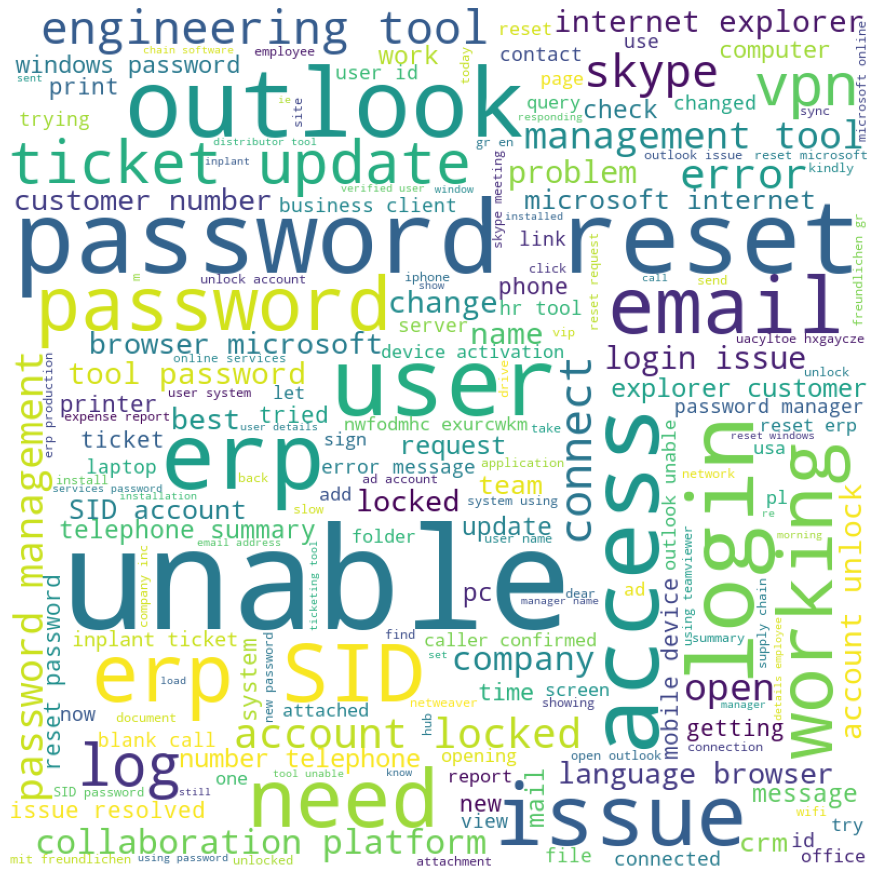

In [ ]:
# Word Cloud for all tickets assigned to GRP_0
generate_word_cloud(' '.join(clean_data[clean_data['Assignment group'] == 'GRP_0'].Clean_Description.str.strip()))

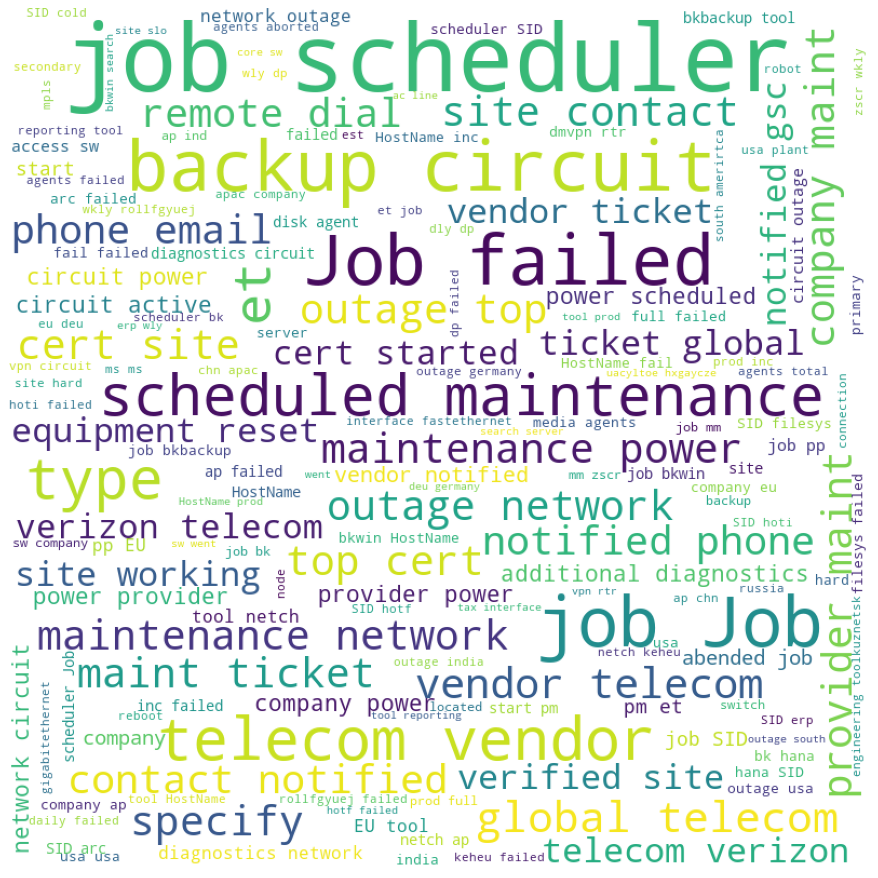

In [ ]:
# Word Cloud for all tickets assigned to GRP_8
generate_word_cloud(' '.join(clean_data[clean_data['Assignment group'] == 'GRP_8'].Clean_Description.str.strip()))

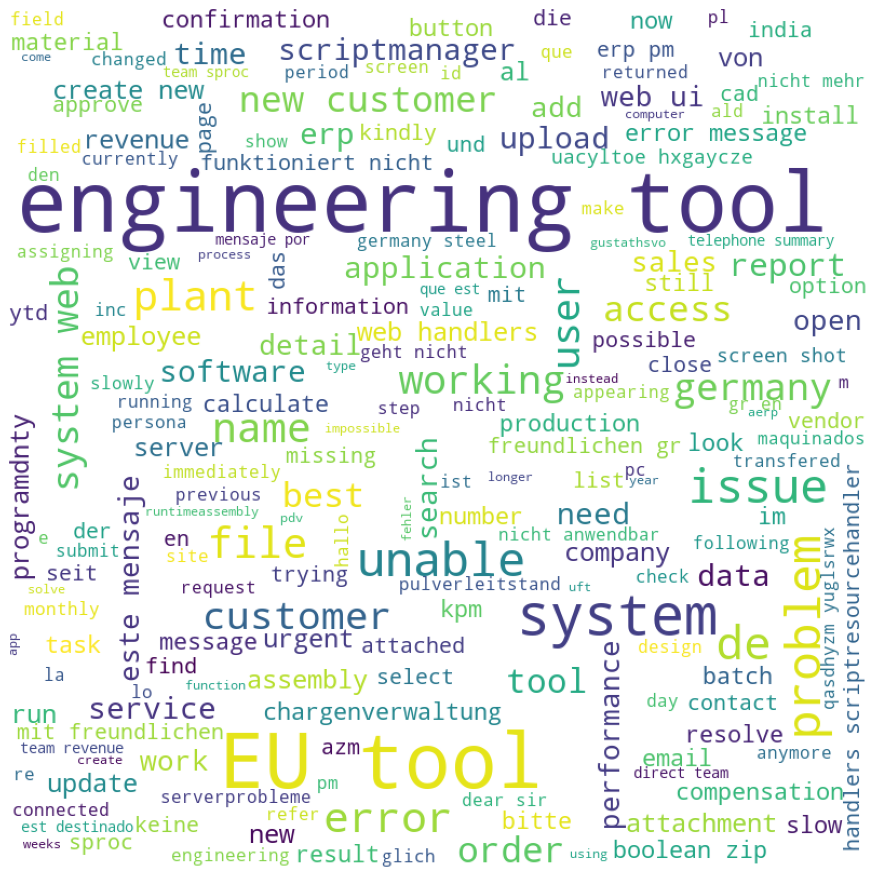

In [ ]:
# Word Cloud for all tickets assigned to GRP_25
generate_word_cloud(' '.join(clean_data[clean_data['Assignment group'] == 'GRP_25'].Clean_Description.str.strip()))

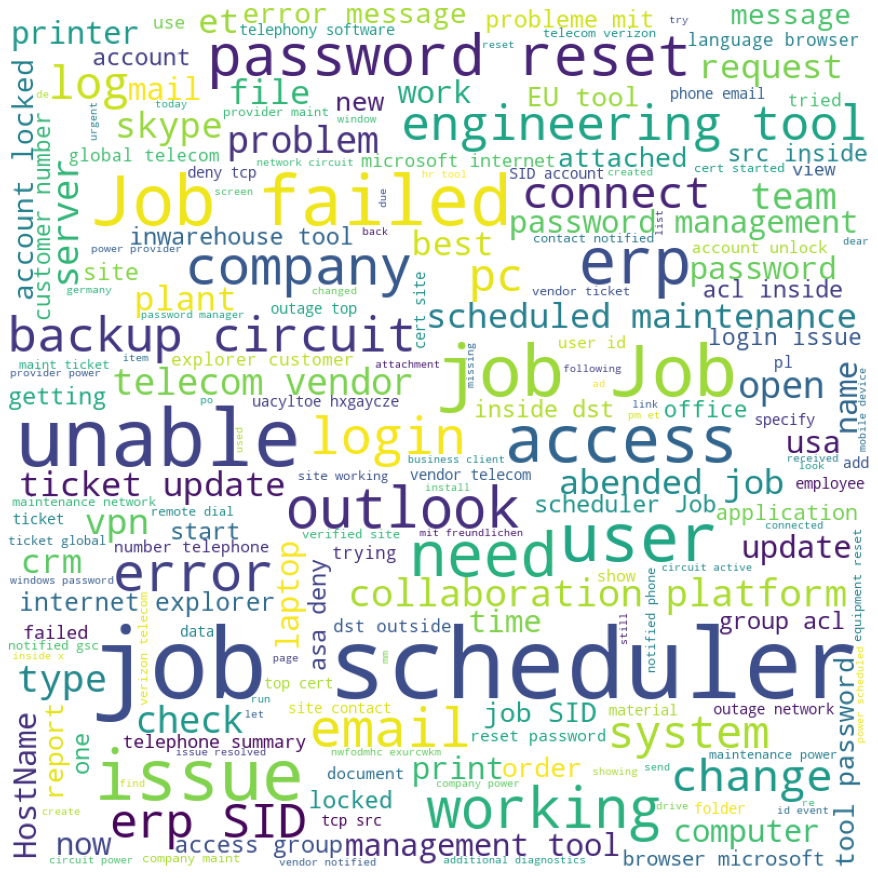

In [ ]:
# Generate wordcloud for Clean_Description field
generate_word_cloud(' '.join(clean_data.Clean_Description.str.strip()))